# Modeling

### Import Relevant Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer, snowball
from nltk.corpus import stopwords
from nltk import FreqDist
from wordcloud import WordCloud
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.util import ngrams
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder 
from nltk.util import ngrams

nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import plot_confusion_matrix, classification_report, r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

import time

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\capta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Read in Processed Data

In [2]:
df = pd.read_parquet('./Data/processed_reports.parquet')

In [3]:
df.reset_index(inplace=True)

In [4]:
df.drop(['index'],axis=1,inplace=True)

### Create secondary classification target 

In [5]:
df['target'] = df.Round

In [6]:
df.target[df.target >= 6] = 0

In [7]:
df.target[df.target == 1] = 10

In [8]:
df.target[(df.target == 4) | (df.target == 5)] = 1

In [9]:
df.target[df.target == 3] = 2

In [10]:
df.target[df.target == 10] = 3

In [11]:
cleaned_df = df.drop(['report','processed_report','joined_report','weight_y','height_y'],axis=1) 

In [12]:
# Add _col to each column to prevent duplicate naming when combining with the scouting report words
cleaned_df = cleaned_df.add_suffix('_col')

In [13]:
cleaned_df

,player_col,year_col,weight_x_col,height_x_col,pos_rk_col,ovr_rk_col,grade_col,age_col,Round_col,Pick_col,...,tackles_loss_career_col,sacks_career_col,pass_defended_career_col,fumbles_forced_season_col,fumbles_forced_career_col,college_conference_col,speed_col,shuttle_agility_col,cone_agility_col,pos_col
0,Alex Smith,2005.0,217.0,76.125,2.0,3.0,98.0,21.0,1,1,...,NaN,NaN,NaN,NaN,NaN,Mountain West Conference,88.187311,176.485482,136.815911,QB
1,Ronnie Brown,2005.0,233.0,72.250,1.0,4.0,98.0,23.0,1,2,...,NaN,NaN,NaN,NaN,NaN,None,120.996000,168.168738,130.199966,RB
2,Braylon Edwards,2005.0,211.0,74.875,1.0,1.0,99.0,22.0,1,3,...,NaN,NaN,NaN,NaN,NaN,None,107.614900,NaN,NaN,WR
3,Cedric Benson,2005.0,222.0,70.500,3.0,10.0,96.0,22.0,1,4,...,NaN,NaN,NaN,NaN,NaN,None,97.457455,NaN,NaN,RB
4,Carnell Williams,2005.0,217.0,70.875,2.0,6.0,97.0,NaN,1,5,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,RB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,Jeff Gunter,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,252,...,38.5,17.0,4.0,2.0,9.0,Sun Belt Conference,105.744617,144.109521,137.671457,LB
4205,Trenton Gill,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,255,...,NaN,NaN,NaN,NaN,NaN,Atlantic Coast Conference,NaN,NaN,NaN,P
4206,Jesse Luketa,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,256,...,11.5,0.5,6.0,NaN,NaN,Big Ten Conference,88.494256,NaN,NaN,LB
4207,Marquis Hayes,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,257,...,NaN,NaN,NaN,NaN,NaN,Big Twelve Conference,80.603451,NaN,NaN,OL


### TFIDF Vectorizing

In [14]:
tf = TfidfVectorizer(ngram_range=(1,3),min_df=.062,max_df =.75)

In [15]:
X = tf.fit_transform(df.joined_report)

In [16]:
report_df = pd.DataFrame(X.toarray(),columns=tf.get_feature_names())

In [17]:
report_df.columns

Index(['2002', '2003', '2004', '2005', '2006', '2016', 'abil', 'adequ', 'also',
       'appear',
       ...
       'two season', 'upsid', 'valu', 'versatil', 'well', 'work', 'yard',
       'year', 'year starter', 'zone'],
      dtype='object', length=198)

### Merge TFIDF features with all other features

In [18]:
model_df = pd.concat([cleaned_df,report_df],axis=1)

In [19]:
model_df

,player_col,year_col,weight_x_col,height_x_col,pos_rk_col,ovr_rk_col,grade_col,age_col,Round_col,Pick_col,...,two season,upsid,valu,versatil,well,work,yard,year,year starter,zone
0,Alex Smith,2005.0,217.0,76.125,2.0,3.0,98.0,21.0,1,1,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.302746,0.197995,0.0,0.000000
1,Ronnie Brown,2005.0,233.0,72.250,1.0,4.0,98.0,23.0,1,2,...,0.0,0.0,0.0,0.128312,0.0,0.130273,0.338669,0.000000,0.0,0.000000
2,Braylon Edwards,2005.0,211.0,74.875,1.0,1.0,99.0,22.0,1,3,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.261304,0.113928,0.0,0.000000
3,Cedric Benson,2005.0,222.0,70.500,3.0,10.0,96.0,22.0,1,4,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.200609,0.000000,0.0,0.000000
4,Carnell Williams,2005.0,217.0,70.875,2.0,6.0,97.0,NaN,1,5,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.282241,0.061528,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,Jeff Gunter,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,252,...,0.0,0.0,0.0,0.199357,0.0,0.000000,0.000000,0.000000,0.0,0.000000
4205,Trenton Gill,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,255,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.370394,0.000000,0.0,0.000000
4206,Jesse Luketa,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,256,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000
4207,Marquis Hayes,2022.0,NaN,NaN,NaN,NaN,NaN,23.0,7,257,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.237427


### Linear Regression

In [20]:
# Set X and y
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

# Save X_test columns to add to predictions after modeling
player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

# Drop unneeded or data leakage columns
X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

# Get numerical and categorical columns to breakup 
num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

# Numerical transformer pipeline
num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

# Categorical transformer pipeline
cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

# Column transformer of numerical and categorical transformers
transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

# Pipeline for transformations, sampling and the model
pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('lin',LinearRegression())
])

# Create Grid for GridSearch
grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
}

# GridSearch with Cross Validation of 5
lin = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [21]:
# Fit GridSearch
lin.fit(X_train,y_train)

# Get y_pred
y_pred_lin = lin.predict(X_test)

# Print results
print(r2_score(y_test,y_pred_lin),mean_squared_error(y_test,y_pred_lin));

0.4901565629798307 2530.820585660758


C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\a

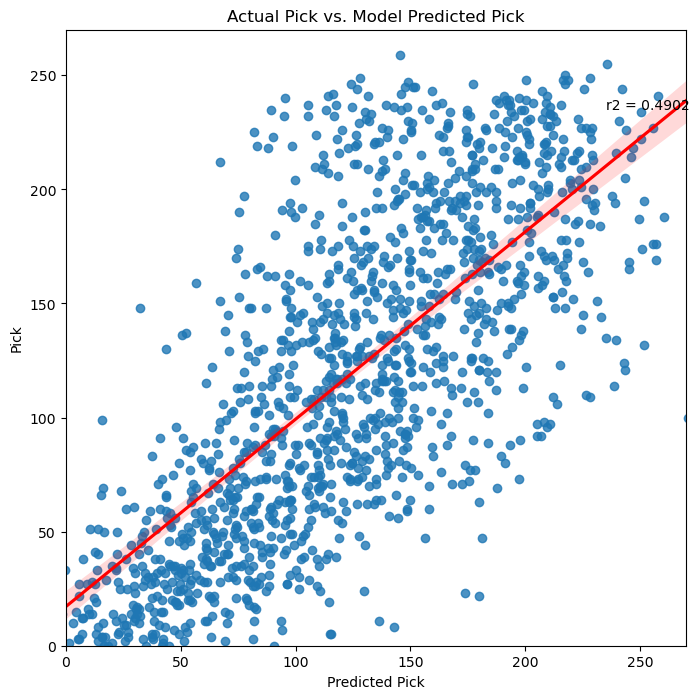

In [22]:
# Graph y_test vs y_pred
fig, ax = plt.subplots(figsize=(8,8))
sns.regplot(x=y_pred_lin,y=y_test,line_kws={"color": "red"})
plt.xlabel('Predicted Pick')
plt.ylabel('Pick')
plt.title('Actual Pick vs. Model Predicted Pick')
plt.xlim(0,270)
plt.ylim(0,270)
plt.annotate(f'r2 = {round(r2_score(y_test,y_pred_lin),4)}',xy=(235,235));

### Random Forest

In [23]:
# Set X and y
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

# Save X_test columns to add to predictions after modeling
player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

# Drop unneeded or data leakage columns
X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

# Get numerical and categorical columns to breakup 
num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

# Numerical transformer pipeline
num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

# Categorical transformer pipeline
cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

# Column transformer of numerical and categorical transformers
transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

# Pipeline for transformations, sampling and the model
rfc_pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('forest',RandomForestRegressor())
])

# Fit model
rfc_pipe.fit(X_train, y_train)

# Create Grid for GridSearch
grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'forest__n_estimators':[102],
#     'forest__criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'forest__max_depth':[24],
    'forest__min_samples_split':[2],
    'forest__min_samples_leaf':[6]
}

# GridSearch with Cross Validation of 5
forest = GridSearchCV(estimator=rfc_pipe,
                          param_grid=grid,
                          cv=5)

In [24]:
# Set start time to see how long the script takes to run
start_time = time.time()

# Fit GridSearch
forest.fit(X_train,y_train)

# Print runtime of script
print(((time.time() - start_time)/60),'minutes')

# Get y_preds
y_pred_forest = forest.predict(X_test)

# Print Results
print(r2_score(y_test,y_pred_forest),mean_squared_error(y_test,y_pred_forest));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\a

3.1599029501279197 minutes
0.6619501880825245 1678.0512621282387


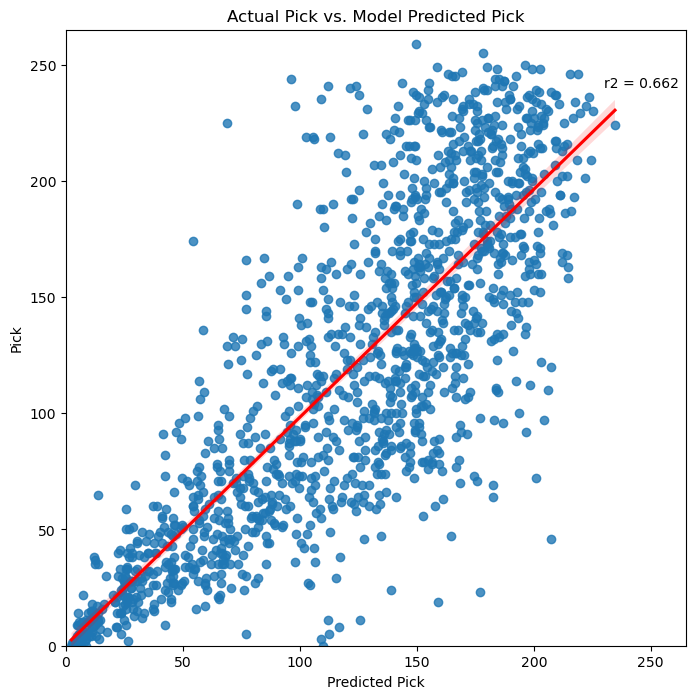

In [25]:
# Graph y_test vs y_pred
fig, ax = plt.subplots(figsize=(8,8))
sns.regplot(x=y_pred_forest,y=y_test,line_kws={"color": "red"})
plt.xlabel('Predicted Pick')
plt.ylabel('Pick')
plt.title('Actual Pick vs. Model Predicted Pick')
plt.xlim(0,265)
plt.ylim(0,265)
plt.annotate(f'r2 = {round(r2_score(y_test,y_pred_forest),3)}',xy=(230,240));

### Get Weights from Random Forest Model

In [26]:
# Get names of the OneHotEncoded Columns
rfc_pipe[0].transformers_[1][1].named_steps['ohe'].get_feature_names()

array(['x0_Atlantic Coast Conference', 'x0_Big East',
       'x0_Big Sky Conference', 'x0_Big South Conference',
       'x0_Big Ten Conference', 'x0_Big Twelve Conference',
       'x0_Central Intercollegiate Athletic Association',
       'x0_Colonial Athletic Association', 'x0_Conference USA',
       'x0_Great Lakes Intercollegiate Athletic Conference',
       'x0_Great Northwest Athletic Conference',
       'x0_Great West Football Conference', 'x0_Gulf South Conference',
       'x0_Independent', 'x0_Ivy League', 'x0_Lone Star Conference',
       'x0_Mid-America Intercollegiate Athletic Association',
       'x0_Mid-American Conference', 'x0_Mid-Eastern Athletic Conference',
       'x0_Minnesota Intercollegiate Athletic Conference',
       'x0_Missouri Valley Football Conference',
       'x0_Mountain West Conference', 'x0_Northeast Conference',
       'x0_Northern Sun Intercollegiate Conference',
       'x0_Ohio Athletic Conference', 'x0_Ohio Valley Conference',
       'x0_Pacific Twelv

In [27]:
# Get all the other X_train columns
X_train.columns.to_list()

['weight_x_col',
 'height_x_col',
 'pos_rk_col',
 'ovr_rk_col',
 'grade_col',
 'age_col',
 'reportlen_col',
 'forty_yd_col',
 'vertical_col',
 'bench_reps_col',
 'broad_jump_col',
 'cone_col',
 'shuttle_col',
 'g_season_col',
 'def_int_season_col',
 'def_int_yds_season_col',
 'def_int_yds_per_int_season_col',
 'def_int_career_col',
 'def_int_yds_career_col',
 'def_int_yds_per_int_career_col',
 'pass_cmp_season_col',
 'pass_att_season_col',
 'pass_cmp_pct_season_col',
 'pass_yds_season_col',
 'pass_yds_per_att_season_col',
 'adj_pass_yds_per_att_season_col',
 'pass_td_season_col',
 'pass_int_season_col',
 'pass_rating_season_col',
 'pass_cmp_career_col',
 'pass_att_career_col',
 'pass_cmp_pct_career_col',
 'pass_yds_career_col',
 'pass_yds_per_att_career_col',
 'adj_pass_yds_per_att_career_col',
 'pass_td_career_col',
 'pass_int_career_col',
 'pass_rating_career_col',
 'rush_att_season_col',
 'rush_yds_season_col',
 'rush_yds_per_att_season_col',
 'rush_td_season_col',
 'rec_season_col'

In [28]:
# Combine the X_train columns and the OneHotEncoded problems in the proper order
# EXTREMELY important as otherwise the feature names will be mismatched
feature_cols = ['weight_x_col',
 'height_x_col',
 'pos_rk_col',
 'ovr_rk_col',
 'grade_col',
 'age_col',
 'reportlen_col',
 'forty_yd_col',
 'vertical_col',
 'bench_reps_col',
 'broad_jump_col',
 'cone_col',
 'shuttle_col',
 'g_season_col',
 'def_int_season_col',
 'def_int_yds_season_col',
 'def_int_yds_per_int_season_col',
 'def_int_career_col',
 'def_int_yds_career_col',
 'def_int_yds_per_int_career_col',
 'pass_cmp_season_col',
 'pass_att_season_col',
 'pass_cmp_pct_season_col',
 'pass_yds_season_col',
 'pass_yds_per_att_season_col',
 'adj_pass_yds_per_att_season_col',
 'pass_td_season_col',
 'pass_int_season_col',
 'pass_rating_season_col',
 'pass_cmp_career_col',
 'pass_att_career_col',
 'pass_cmp_pct_career_col',
 'pass_yds_career_col',
 'pass_yds_per_att_career_col',
 'adj_pass_yds_per_att_career_col',
 'pass_td_career_col',
 'pass_int_career_col',
 'pass_rating_career_col',
 'rush_att_season_col',
 'rush_yds_season_col',
 'rush_yds_per_att_season_col',
 'rush_td_season_col',
 'rec_season_col',
 'rec_yds_season_col',
 'rec_yds_per_rec_season_col',
 'scrim_att_season_col',
 'scrim_yds_season_col',
 'scrim_yds_per_att_season_col',
 'scrim_td_season_col',
 'rush_att_career_col',
 'rush_yds_career_col',
 'rush_yds_per_att_career_col',
 'rush_td_career_col',
 'rec_career_col',
 'rec_yds_career_col',
 'rec_yds_per_rec_career_col',
 'rec_td_career_col',
 'scrim_att_career_col',
 'scrim_yds_career_col',
 'scrim_yds_per_att_career_col',
 'scrim_td_career_col',
 'fumbles_rec_yds_career_col',
 'fumbles_rec_td_career_col',
 'rec_td_season_col',
 'def_int_td_season_col',
 'def_int_td_career_col',
 'fumbles_rec_career_col',
 'fumbles_rec_yds_season_col',
 'fumbles_rec_td_season_col',
 'fumbles_rec_season_col',
 'tackles_solo_season_col',
 'tackles_assists_season_col',
 'tackles_total_season_col',
 'tackles_loss_season_col',
 'sacks_season_col',
 'pass_defended_season_col',
 'tackles_solo_career_col',
 'tackles_assists_career_col',
 'tackles_total_career_col',
 'tackles_loss_career_col',
 'sacks_career_col',
 'pass_defended_career_col',
 'fumbles_forced_season_col',
 'fumbles_forced_career_col',
 'x0_Atlantic Coast Conference', 'x0_Big East',
       'x0_Big Sky Conference', 'x0_Big South Conference',
       'x0_Big Ten Conference', 'x0_Big Twelve Conference',
       'x0_Central Intercollegiate Athletic Association',
       'x0_Colonial Athletic Association', 'x0_Conference USA',
       'x0_Great Lakes Intercollegiate Athletic Conference',
       'x0_Great Northwest Athletic Conference',
       'x0_Great West Football Conference', 'x0_Gulf South Conference',
       'x0_Independent', 'x0_Ivy League', 'x0_Lone Star Conference',
       'x0_Mid-America Intercollegiate Athletic Association',
       'x0_Mid-American Conference', 'x0_Mid-Eastern Athletic Conference',
       'x0_Minnesota Intercollegiate Athletic Conference',
       'x0_Missouri Valley Football Conference',
       'x0_Mountain West Conference', 'x0_Northeast Conference',
       'x0_Northern Sun Intercollegiate Conference',
       'x0_Ohio Athletic Conference', 'x0_Ohio Valley Conference',
       'x0_Pacific Twelve Conference', 'x0_Patriot League',
       'x0_Pennsylvania State Athletic Conference',
       'x0_Pioneer Football League', 'x0_South Atlantic Conference',
       'x0_Southeastern Conference', 'x0_Southern Conference',
       'x0_Southern Intercollegiate Athletic Conference',
       'x0_Southland Conference', 'x0_Southwestern Athletic Conference',
       'x0_Sun Belt Conference', 'x0_Western Athletic Conference',
       'x0_Wisconsin Intercollegiate Athletic Conference','x0_None','speed_col',
 'shuttle_agility_col',
 'cone_agility_col','x1_DB', 'x1_DE', 'x1_DL', 'x1_DT', 'x1_FB', 'x1_K', 'x1_LB',
       'x1_LS', 'x1_OL', 'x1_P', 'x1_QB', 'x1_RB', 'x1_S', 'x1_TE',
       'x1_WR','2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2016',
 'abil',
 'adequ',
 'also',
 'appear',
 'arm',
 'athlet',
 'athlet abil',
 'athletic',
 'averag',
 'back',
 'backup',
 'ball',
 'ball skill',
 'best',
 'better',
 'big',
 'block',
 'blocker',
 'bodi',
 'burst',
 'career',
 'catch',
 'class',
 'close',
 'colleg',
 'combin',
 'come',
 'concern',
 'consist',
 'contribut',
 'corner',
 'could',
 'coverag',
 'day',
 'defend',
 'defens',
 'develop',
 'draft',
 'durabl',
 'earli',
 'edg',
 'effect',
 'eight',
 'elit',
 'end',
 'end speed',
 'enough',
 'excel',
 'experi',
 'explos',
 'field',
 'final',
 'finish',
 'first',
 'fit',
 'five',
 'flash',
 'flash abil',
 'footbal',
 'forc',
 'four',
 'frame',
 'freshman',
 'fumbl',
 'game',
 'get',
 'good',
 'grade',
 'great',
 'guard',
 'hand',
 'high',
 'howev',
 'ideal',
 'improv',
 'inconsist',
 'injuri',
 'insid',
 'instinct',
 'intercept',
 'job',
 'junior',
 'lack',
 'lack ideal',
 'last',
 'late',
 'left',
 'length',
 'level',
 'like',
 'limit',
 'line',
 'lineback',
 'long',
 'loss',
 'lot',
 'make',
 'man',
 'miss',
 'move',
 'much',
 'natur',
 'need',
 'nfl',
 'offens',
 'one',
 'outsid',
 'outstand',
 'overal',
 'pass',
 'pass rusher',
 'physic',
 'pick',
 'play',
 'play game',
 'player',
 'point',
 'posit',
 'possess',
 'potenti',
 'power',
 'pro',
 'product',
 'project',
 'prospect',
 'quarterback',
 'quick',
 'rang',
 'receiv',
 'record',
 'redshirt',
 'return',
 'right',
 'round',
 'round pick',
 'rout',
 'rout runner',
 'run',
 'run defend',
 'runner',
 'rush',
 'rusher',
 'sack',
 'safeti',
 'scheme',
 'season',
 'second',
 'senior',
 'set',
 'short',
 'show',
 'six',
 'size',
 'skill',
 'special',
 'special team',
 'speed',
 'start',
 'start game',
 'starter',
 'still',
 'strength',
 'strong',
 'tackl',
 'tackl loss',
 'take',
 'team',
 'techniqu',
 'term',
 'three',
 'three season',
 'tight',
 'time',
 'top',
 'top end',
 'top end speed',
 'total',
 'touchdown',
 'tough',
 'true',
 'true freshman',
 'two',
 'two season',
 'upsid',
 'valu',
 'versatil',
 'well',
 'work',
 'yard',
 'year',
 'year starter',
 'zone']

In [29]:
# Get the weight values of the Random Forest Model
weights = rfc_pipe[-1].feature_importances_

In [30]:
# Zip the names and the weights together into a DataFrame
coefs = pd.DataFrame(zip(feature_cols,weights))

### Sorted Results of the Weights of the Random Forest Model

In [31]:
coefs.sort_values(by=1,ascending=False).head(20)

,0,1
3,ovr_rk_col,0.511704
4,grade_col,0.133505
6,reportlen_col,0.015114
84,x0_Atlantic Coast Conference,0.011141
2,pos_rk_col,0.009262
140,x1_TE,0.006247
1,height_x_col,0.005962
0,weight_x_col,0.005656
7,forty_yd_col,0.005507
85,x0_Big East,0.004992


### KNN

In [32]:
# Set X and y
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

# Save X_test columns to add to predictions after modeling
player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

# Drop unneeded or data leakage columns
X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

# Get numerical and categorical columns to breakup 
num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

# Numerical transformer pipeline
num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

# Categorical transformer pipeline
cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

# Column transformer of numerical and categorical transformers
transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

# Pipeline for transformations, sampling and the model
pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('knn',KNeighborsRegressor())
])

# Create Grid for GridSearch
grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'knn__n_neighbors':[30,40]
#     'forest__criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
#     'forest__max_depth':[4,12,None],
#     'forest__min_samples_split':[1,2,3],
#     'forest__min_samples_leaf':[1,2,3]
}

# GridSearch with Cross Validation of 5
knn = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [33]:
# Set start time to see how long the script takes to run
start_time = time.time()

# Fit GridSearch
knn.fit(X_train,y_train)

# Print runtime of script
print(((time.time() - start_time)/60),'minutes')

# Get y_preds
y_pred_knn = knn.predict(X_test)

# Print Results
print(r2_score(y_test,y_pred_knn),mean_squared_error(y_test,y_pred_knn));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\

0.08707298437754313 minutes
0.20151397149746042 3963.618498470122


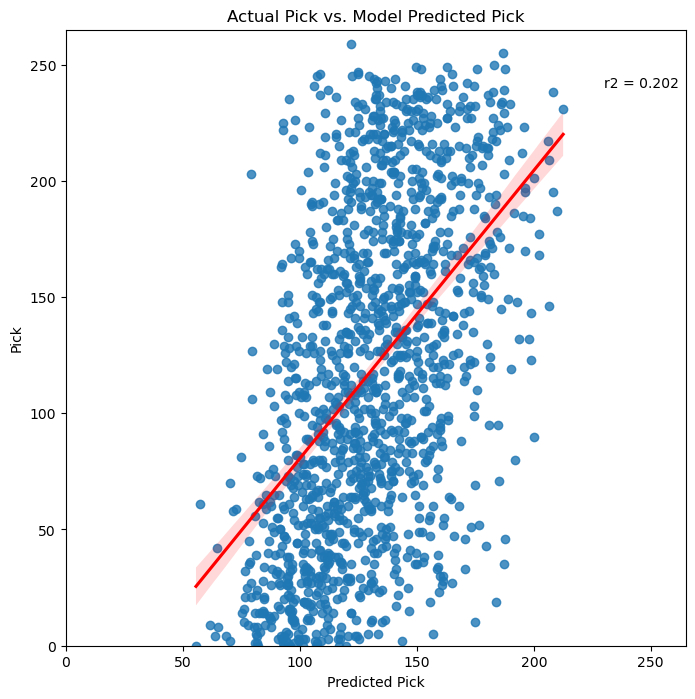

In [34]:
# Graph y_test vs y_pred
fig, ax = plt.subplots(figsize=(8,8))
sns.regplot(x=y_pred_knn,y=y_test,line_kws={"color": "red"})
plt.xlabel('Predicted Pick')
plt.ylabel('Pick')
plt.title('Actual Pick vs. Model Predicted Pick')
plt.xlim(0,265)
plt.ylim(0,265)
plt.annotate(f'r2 = {round(r2_score(y_test,y_pred_knn),3)}',xy=(230,240));

### Decision Tree

In [35]:
# Set X and y
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

# Save X_test columns to add to predictions after modeling
player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

# Drop unneeded or data leakage columns
X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

# Get numerical and categorical columns to breakup 
num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

# Numerical transformer pipeline
num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

# Categorical transformer pipeline
cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

# Column transformer of numerical and categorical transformers
transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

# Pipeline for transformations, sampling and the model
pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('tree',DecisionTreeRegressor(random_state=42))
])

# Create Grid for GridSearch
grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)]
#     'tree__n_estimators':[75,100,125],
#     'tree__criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
#     'tree__max_depth':[4,12,None],
#     'tree__min_samples_split':[1,2,3],
#     'tree__min_samples_leaf':[1,2,3]
}

# GridSearch with Cross Validation of 5
tree = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [36]:
# Set start time to see how long the script takes to run
start_time = time.time()

# Fit GridSearch
tree.fit(X_train,y_train)

# Print runtime of script
print(((time.time() - start_time)/60),'minutes')

# Get y_preds
y_pred_tree = tree.predict(X_test)

# Print Results
print(r2_score(y_test,y_pred_tree),mean_squared_error(y_test,y_pred_tree));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\a

0.1054610808690389 minutes
0.34642468190258413 3244.29373650108


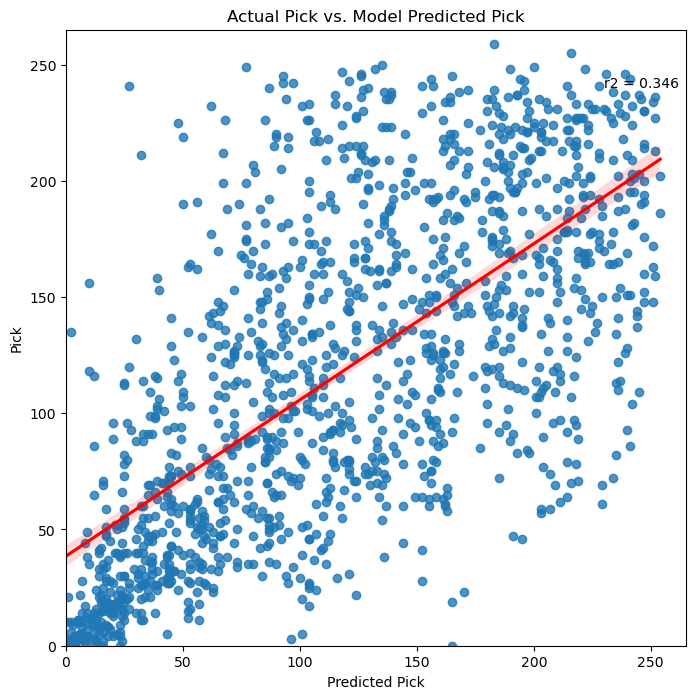

In [37]:
# Graph y_test vs y_pred
fig, ax = plt.subplots(figsize=(8,8))
sns.regplot(x=y_pred_tree,y=y_test,line_kws={"color": "red"})
plt.xlabel('Predicted Pick')
plt.ylabel('Pick')
plt.title('Actual Pick vs. Model Predicted Pick')
plt.xlim(0,265)
plt.ylim(0,265)
plt.annotate(f'r2 = {round(r2_score(y_test,y_pred_tree),3)}',xy=(230,240));

### XGBoost

In [38]:
# Set X and y
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

# Save X_test columns to add to predictions after modeling
player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

# Drop unneeded or data leakage columns
X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

# Get numerical and categorical columns to breakup 
num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

# Numerical transformer pipeline
num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

# Categorical transformer pipeline
cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

# Column transformer of numerical and categorical transformers
transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

# Pipeline for transformations, sampling and the model
pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('xgb',XGBRegressor())
])

# Create Grid for GridSearch
grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'xgb__max_depth':[2,1],
    'xgb__eta':[.2,.22],
    'xgb__gamma':[0,.15]
#     'forest__min_samples_split':[1,2,3],
#     'forest__min_samples_leaf':[1,2,3]
}

# GridSearch with Cross Validation of 5
xgb = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [39]:
# Set start time to see how long the script takes to run
start_time = time.time()

# Fit GridSearch
xgb.fit(X_train,y_train)

# Print runtime of script
print(((time.time() - start_time)/60),'minutes')

# Get y_preds
y_pred_xgb = xgb.predict(X_test)

# Print Results
print(r2_score(y_test,y_pred_xgb),mean_squared_error(y_test,y_pred_xgb));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta

0.9284277478853862 minutes
0.633949529706585 1817.0442107166475


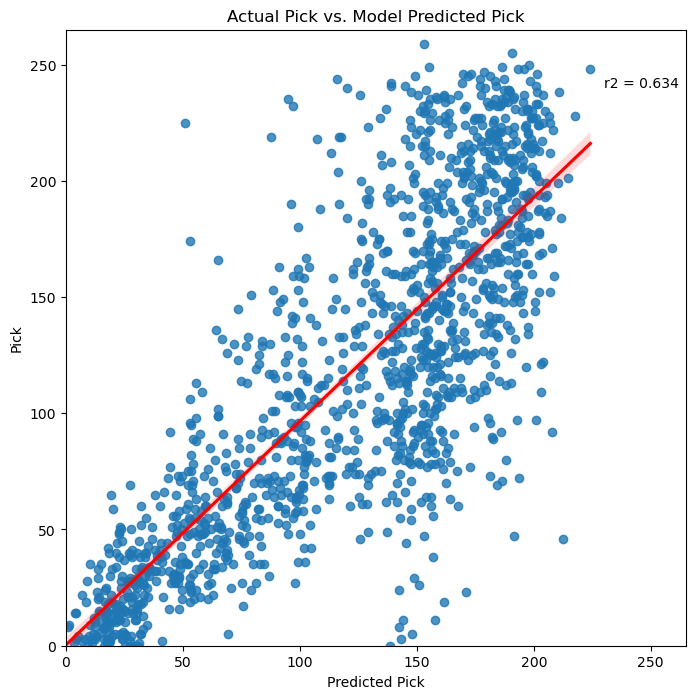

In [40]:
# Graph y_test vs y_pred
fig, ax = plt.subplots(figsize=(8,8))
sns.regplot(x=y_pred_xgb,y=y_test,line_kws={"color": "red"})
plt.xlabel('Predicted Pick')
plt.ylabel('Pick')
plt.title('Actual Pick vs. Model Predicted Pick')
plt.xlim(0,265)
plt.ylim(0,265)
plt.annotate(f'r2 = {round(r2_score(y_test,y_pred_xgb),3)}',xy=(230,240));

### ADABoost

In [41]:
# Set X and y
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

# Save X_test columns to add to predictions after modeling
player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

# Drop unneeded or data leakage columns
X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

# Get numerical and categorical columns to breakup 
num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

# Numerical transformer pipeline
num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

# Categorical transformer pipeline
cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

# Column transformer of numerical and categorical transformers
transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

# Pipeline for transformations, sampling and the model
pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('ada',AdaBoostRegressor(random_state=42))
])

# Create Grid for GridSearch
grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'ada__n_estimators':[42,40],
    'ada__learning_rate':[.35],
    'ada__loss':['linear','square','exponential']
#     'forest__min_samples_split':[1,2,3],
#     'forest__min_samples_leaf':[1,2,3]
}

# GridSearch with Cross Validation of 5
ada = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [42]:
# Set start time to see how long the script takes to run
start_time = time.time()

# Fit GridSearch
ada.fit(X_train,y_train)

# Print runtime of script
print(((time.time() - start_time)/60),'minutes')

# Get y_preds
y_pred_ada = ada.predict(X_test)

# Print Results
print(r2_score(y_test,y_pred_ada),mean_squared_error(y_test,y_pred_ada));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta

2.9828298250834147 minutes
0.6325245975566219 1824.1174558669106


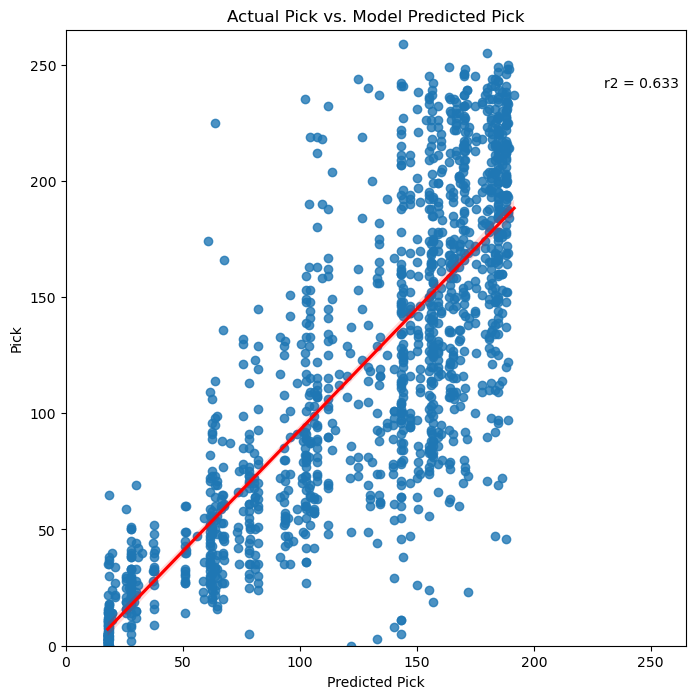

In [43]:
# Graph y_test vs y_pred
fig, ax = plt.subplots(figsize=(8,8))
sns.regplot(x=y_pred_ada,y=y_test,line_kws={"color": "red"})
plt.xlabel('Predicted Pick')
plt.ylabel('Pick')
plt.title('Actual Pick vs. Model Predicted Pick')
plt.xlim(0,265)
plt.ylim(0,265)
plt.annotate(f'r2 = {round(r2_score(y_test,y_pred_ada),3)}',xy=(230,240));

### GradientBoost

In [44]:
# Set X and y
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

# Save X_test columns to add to predictions after modeling
player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

# Drop unneeded or data leakage columns
X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

# Get numerical and categorical columns to breakup 
num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

# Numerical transformer pipeline
num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

# Categorical transformer pipeline
cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

# Column transformer of numerical and categorical transformers
transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

# Pipeline for transformations, sampling and the model
pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('grad',GradientBoostingRegressor(random_state=42))
])

# Create Grid for GridSearch
grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'grad__n_estimators':[94],
    'grad__learning_rate':[.05],
#     'grad__loss':['absolute_error','squared_error','huber','quantile'],
    'grad__min_samples_split':[2],
    'grad__min_samples_leaf':[1],
    'grad__max_depth':[4],
    'grad__min_impurity_decrease':[.31]
}

# GridSearch with Cross Validation of 5
grad = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [45]:
# Set start time to see how long the script takes to run
start_time = time.time()

# Fit GridSearch
grad.fit(X_train,y_train)

# Print runtime of script
print(((time.time() - start_time)/60),'minutes')

# Get y_preds
y_pred_grad = grad.predict(X_test)

# Print Results
print(r2_score(y_test,y_pred_grad),mean_squared_error(y_test,y_pred_grad));

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\a

1.6695196151733398 minutes
0.6524671286024645 1725.1243838054565


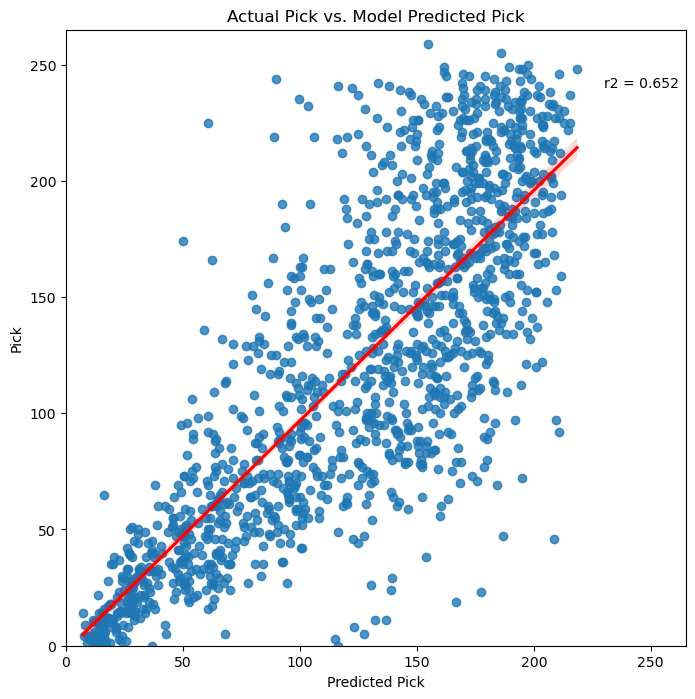

In [46]:
# Graph y_test vs y_pred
fig, ax = plt.subplots(figsize=(8,8))
sns.regplot(x=y_pred_grad,y=y_test,line_kws={"color": "red"})
plt.xlabel('Predicted Pick')
plt.ylabel('Pick')
plt.title('Actual Pick vs. Model Predicted Pick')
plt.xlim(0,265)
plt.ylim(0,265)
plt.annotate(f'r2 = {round(r2_score(y_test,y_pred_grad),3)}',xy=(230,240));

### Analyze Results of Top Random Forest Model

In [47]:
# Create DataFrame of X_test, y_test, y_preds
results = pd.concat([player_name.reset_index(),player_round.reset_index(),player_year.reset_index(),X_test.reset_index(),pd.Series(y_pred_forest),pd.Series(y_test)],axis=1)

In [48]:
results

,index,player_col,index,Round_col,index,year_col,index,weight_x_col,height_x_col,pos_rk_col,...,valu,versatil,well,work,yard,year,year starter,zone,0,1
0,1073,DeAndre Wright,1073,6,1073,2009.0,1073,198.0,70.750,41.0,...,0.00000,0.000000,0.287967,0.000000,0.000000,0.000000,0.000000,0.0,193.664872,199
1,144,Adrian McPherson,144,5,144,2005.0,144,218.0,75.500,9.0,...,0.00000,0.000000,0.098724,0.000000,0.000000,0.083411,0.000000,0.0,123.212988,151
2,2380,Jon Feliciano,2380,4,2380,2015.0,2380,323.0,75.875,17.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,191.258418,127
3,184,DeAndra Cobb,184,6,184,2005.0,184,196.0,69.750,24.0,...,0.00000,0.082646,0.000000,0.000000,0.218138,0.063405,0.000000,0.0,188.924112,200
4,2587,Kyler Fackrell,2587,3,2587,2016.0,2587,245.0,77.000,10.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,135.631904,87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384,2282,Phillip Dorsett,2282,1,2282,2015.0,2282,185.0,69.750,6.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,25.055990,28
1385,2986,Treyvon Hester,2986,7,2986,2017.0,2986,300.0,74.375,20.0,...,0.19871,0.000000,0.000000,0.165464,0.000000,0.250062,0.179509,0.0,187.387439,243
1386,1078,Ra'Shon Harris,1078,6,1078,2009.0,1078,298.0,75.750,24.0,...,0.00000,0.000000,0.000000,0.404393,0.000000,0.000000,0.000000,0.0,174.377779,204
1387,1413,Martez Wilson,1413,3,1413,2011.0,1413,250.0,76.000,4.0,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,64.996622,71


### Create difference columns between actual pick number and modeled pick projection

In [49]:
# Add 1 to the 
results['difference'] = results[0] - results[1]
results['abs_difference'] = (results[0] - results[1]).abs()

In [50]:
# Average each pick is off by
results.abs_difference.mean()

31.10347040186479

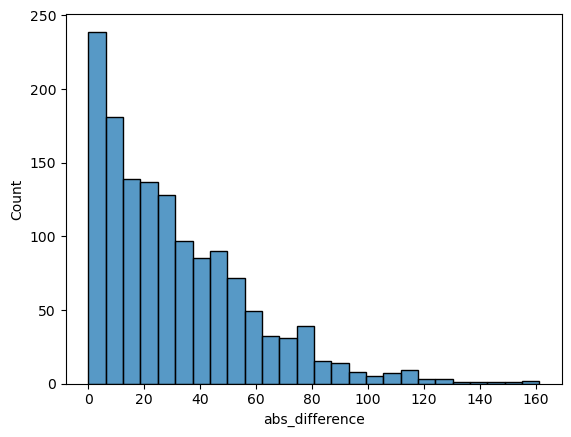

In [75]:
sns.histplot(results.abs_difference);

### Create DataFrame of the best results where the pick was projected within 16 picks

In [52]:
best = results[results.abs_difference <= 16]

In [53]:
best

,index,player_col,index,Round_col,index,year_col,index,weight_x_col,height_x_col,pos_rk_col,...,well,work,yard,year,year starter,zone,0,1,difference,abs_difference
0,1073,DeAndre Wright,1073,6,1073,2009.0,1073,198.0,70.750,41.0,...,0.287967,0.0,0.000000,0.000000,0.0,0.0,193.664872,199,-5.335128,5.335128
3,184,DeAndra Cobb,184,6,184,2005.0,184,196.0,69.750,24.0,...,0.000000,0.0,0.218138,0.063405,0.0,0.0,188.924112,200,-11.075888,11.075888
5,2768,Charles Harris,2768,1,2768,2017.0,2768,253.0,74.750,1.0,...,0.000000,0.0,0.000000,0.273181,0.0,0.0,30.058472,21,9.058472,9.058472
9,2862,Mack Hollins,2862,4,2862,2017.0,2862,221.0,76.000,10.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,107.143610,117,-9.856390,9.856390
11,3290,Irv Smith Jr.,3290,2,3290,2019.0,3290,242.0,74.375,3.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,40.214984,49,-8.785016,8.785016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,3053,D.J. Chark,3053,2,3053,2018.0,3053,199.0,74.875,6.0,...,0.000000,0.0,0.422382,0.000000,0.0,0.0,54.319474,60,-5.680526,5.680526
1379,2042,Brandin Cooks,2042,1,2042,2014.0,2042,189.0,69.750,4.0,...,0.398851,0.0,0.000000,0.000000,0.0,0.0,21.103887,19,2.103887,2.103887
1380,1632,Casey Hayward,1632,2,1632,2012.0,1632,192.0,71.375,8.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,60.949467,61,-0.050533,0.050533
1384,2282,Phillip Dorsett,2282,1,2282,2015.0,2282,185.0,69.750,6.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,25.055990,28,-2.944010,2.944010


### Create DataFrame of the worst results where the pick was projected more than 64 picks away

In [54]:
worst = results[results.abs_difference >= 64]

### Normalized counts of players that were the best and worst by round

In [55]:
best.Round_col.value_counts(normalize=True)

1    0.264
5    0.162
6    0.154
2    0.154
3    0.126
4     0.11
7     0.03
Name: Round_col, dtype: Float64

In [56]:
worst.Round_col.value_counts(normalize=True)

7    0.318471
3    0.248408
6    0.121019
2    0.095541
1    0.082803
4    0.076433
5    0.057325
Name: Round_col, dtype: Float64

The Model was best at predicting players in round 1 and was worst at projecting players in round 7

### Position Breakdown of the model's best and worst projections

In [57]:
# Count of the normalized best position minus the actual position breakdown
best_pos = best.pos_col.value_counts(normalize=True) - results.pos_col.value_counts(normalize=True)

# Count of the normalized worst position minus the actual position breakdown
worst_pos = worst.pos_col.value_counts(normalize=True) - results.pos_col.value_counts(normalize=True)

In [58]:
best_pos.sort_values(ascending=False)

DE    0.022167
WR    0.021210
QB    0.004004
P     0.003521
DT    0.002887
LS    0.001840
RB   -0.001113
CB   -0.001916
K    -0.002479
DL   -0.003199
TE   -0.006396
DB   -0.007431
OL   -0.008706
LB   -0.010550
S    -0.012397
FB         NaN
Name: pos_col, dtype: float64

In [59]:
worst_pos.sort_values(ascending=False)

OL    0.029486
CB    0.026147
S     0.024927
DB    0.017957
DL    0.011909
K     0.006259
DT    0.002059
P    -0.000110
QB   -0.009410
LB   -0.016270
WR   -0.016880
TE   -0.018549
DE   -0.024139
RB   -0.029788
FB         NaN
LS         NaN
Name: pos_col, dtype: float64

The model was best at predicting WR and DEs while it struggled with OL, S, CB, and DB. 3 of the 4 worst positions were all the secondary positions.

In [60]:
# Breakdown of the positions that were the best in the first round
best.pos_col[best.Round_col == 1].value_counts(normalize=True) - results.pos_col[results.Round_col == 1].value_counts(normalize=True)

CB   -0.007130
DB   -0.000446
DE    0.012478
DL   -0.003119
DT    0.000000
LB    0.015152
OL   -0.028520
QB   -0.006239
RB    0.016934
S          NaN
TE    0.001337
WR    0.020945
Name: pos_col, dtype: float64

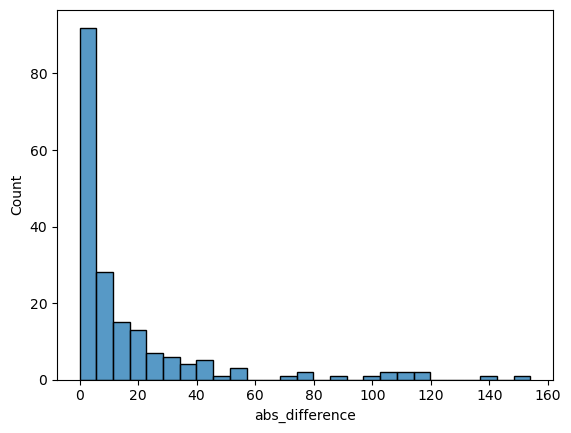

In [61]:
sns.histplot(results[results.Round_col == 1].abs_difference);

### Checking how the word develop appears in round 1 and when the difference is greater than 32

In [62]:
one_round = results[results.Round_col == 1]

In [63]:
one_round.develop

5       0.000000
21      0.000000
25      0.065799
31      0.155973
34      0.000000
          ...   
1349    0.000000
1371    0.000000
1373    0.000000
1379    0.000000
1384    0.000000
Name: develop, Length: 187, dtype: float64

In [64]:
miss_one = one_round[one_round.abs_difference > 32]

In [65]:
miss_one.develop.mean()

0.05992217810455673

In [66]:
one_round.develop.mean()

0.030089307317340747

### Average Differences by Round

In [67]:
results[results.Round_col == 1].abs_difference.mean()

17.395908145087237

In [68]:
results[results.Round_col == 2].abs_difference.mean()

26.075363419439093

In [69]:
results[results.Round_col == 3].abs_difference.mean()

37.751735336559214

In [70]:
results[results.Round_col == 4].abs_difference.mean()

30.449464320771472

In [71]:
results[results.Round_col == 5].abs_difference.mean()

25.65849792049852

In [72]:
results[results.Round_col == 6].abs_difference.mean()

27.815049533183082

In [73]:
results[results.Round_col == 7].abs_difference.mean()

53.329978388526804

### Breakdown of features by Pos

In [74]:
cleaned_df[cleaned_df.Round_col == 1].groupby('pos_col').mean().sort_values(by='ovr_rk_col')

,year_col,weight_x_col,height_x_col,pos_rk_col,ovr_rk_col,grade_col,age_col,Round_col,Pick_col,target_col,...,tackles_assists_career_col,tackles_total_career_col,tackles_loss_career_col,sacks_career_col,pass_defended_career_col,fumbles_forced_season_col,fumbles_forced_career_col,speed_col,shuttle_agility_col,cone_agility_col
pos_col,,,,,,,,,,,,,,,,,,,,,
TE,2012.875000,251.062500,76.695312,1.312500,17.062500,91.625000,22.125000,1.0,20.3125,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.666030,144.407558,145.712496
DT,2013.204082,308.595745,75.111702,2.765957,17.489362,91.829787,22.083333,1.0,17.081633,3.0,...,54.066667,114.133333,22.888889,9.444444,4.388889,1.736842,2.379310,97.849975,136.961771,143.358176
QB,2013.962264,226.826923,75.509615,2.480769,18.192308,91.480769,22.134615,1.0,9.90566,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.558852,137.959072,133.613383
DE,2012.900000,270.151515,76.119318,2.909091,18.242424,91.818182,22.014493,1.0,15.742857,3.0,...,49.812500,118.468750,32.085938,18.460938,5.000000,2.500000,3.877193,109.577507,148.839163,146.681849
RB,2011.444444,217.138889,70.961806,2.111111,18.833333,92.083333,21.735294,1.0,17.138889,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.335770,132.875457,127.253084
WR,2014.043478,205.095238,73.043651,3.349206,20.476190,90.857143,21.692308,1.0,17.347826,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106.740370,129.574828,123.432178
LB,2013.868852,244.793103,74.413793,2.310345,21.327586,90.603448,21.983333,1.0,16.836066,3.0,...,83.962963,196.481481,27.861111,12.000000,6.063830,2.451613,4.125000,110.896430,156.247868,141.032109
DB,2010.619048,199.245902,70.651639,2.750000,21.983333,91.483333,22.129032,1.0,18.936508,3.0,...,49.471698,159.037736,8.650943,2.208333,15.086957,1.444444,2.047619,103.610605,140.182586,126.084150
OL,2014.135922,313.936170,77.140957,2.563830,23.159574,90.255319,22.274510,1.0,16.834951,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.208684,133.981217,138.969886
